In [101]:
import pandas as pd
from utils import get_ctx
%matplotlib inline


In [102]:
# Connect to internal db via proprietary Snowflake connector
context = get_ctx()

Enter username:  STANISLAV.IVANOV_PROG
Enter password:  ········


Connected succesfully!


# 1. Test setup 

* #### What is the goal of the test?
    - Do we aim for more retention, revenue, PUR, etc?
* #### How to measure success?
    - What KPI?
* #### How long should we run it?
    - 2 weeks is good default period
* #### How big should my group size be?
    - Tricky one, depending on the tested KPI. If it's something that happens rarely (like PUR), you might need a bigger sample

In [3]:
# AA test to determine sample size
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis 

# effect_size has to be positive
effect = 0.1 # Minimum detectable effect; or the smallest acceptable change in the test group for the implementation to make sense
alpha = 0.05 # probability of rejecting the null hypothesys when it is true
power = 0.9 #The probability of correctly ideftifying the effect when there is indeed effect

# perform power analysis 
analysis = TTestIndPower()
result = analysis.solve_power(effect, power = power,nobs1= None, ratio = 1.0, alpha = alpha)
print('Sample Size for each group: %.3f' % round(result))

Sample Size for each group: 2102.000


# 2. Support during a live test

* #### Data allocation to the groups
    - expected amounts
    - independent
    - equal between groups
* #### Measuring preliminary results
    - Do not stop it early, even if results are good!

# 3. Analysis

* #### Group size testing
* #### EDA, plots, sanity checks
* #### Bootstrap sampling
    

## 3.1. Group size testing
##### Done by performing a Chi-square test
Measuring the difference between the expected frequencies and the observed frequencies of the 2 groups

In [98]:
q0 = open('query0.sql', 'r')
sql_stmt0 = q0.read()
df0 = pd.read_sql(sql_stmt0, context)

In [99]:
# user identifier and campaign (control or test)
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67236 entries, 0 to 67235
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FED_ID    67236 non-null  object
 1   CAMPAIGN  67236 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [100]:
#df containint the split of the campaigns between users
print(df0.groupby('CAMPAIGN')['FED_ID'].count())

print(' ')
print('chi^2: ')
from scipy.stats import chisquare 
chisquare(df0.groupby('CAMPAIGN')['FED_ID'].count().values,f_exp = [df0.groupby('CAMPAIGN')['FED_ID'].count().values.mean(),df0.groupby('CAMPAIGN')['FED_ID'].count().values.mean()])

CAMPAIGN
Group1    33691
Group4    33545
Name: FED_ID, dtype: int64
 
chi^2: 


Power_divergenceResult(statistic=0.3170325420905467, pvalue=0.5733964596758977)

## 3.2. EDA, plots, sanity checks
##### Relevant groupings and aggregations of data
Example with a PUR ortiented test where we measure the PUR, ARPU, Revenue and Number of Players aggregated daily and overall 

In [71]:
q1 = open('query1.sql', 'r')
sql_stmt1 = q1.read()
df = pd.read_sql(sql_stmt1, context)

In [72]:
df.groupby('CAMPAIGN')['FED_ID'].nunique()

CAMPAIGN
Group1    33381
Group4    33210
Name: FED_ID, dtype: int64

In [73]:
df['ACTIVE_DATE'] = pd.to_datetime(df['ACTIVE_DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157673 entries, 0 to 157672
Data columns (total 38 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   FED_ID                             157673 non-null  object        
 1   GAME_ID                            157673 non-null  int64         
 2   GAME_BUILD                         157673 non-null  object        
 3   BUILD                              157673 non-null  object        
 4   PLATFORM                           157673 non-null  object        
 5   ACTIVE_DATE                        157673 non-null  datetime64[ns]
 6   INSTALL_DATE                       157673 non-null  object        
 7   RETENTION_DAY                      157673 non-null  int64         
 8   VERSION                            157673 non-null  object        
 9   COUNTRY                            157673 non-null  object        
 10  INSTALL_COUNTRY     

In [74]:
df2 = df.loc[df['ACTIVE_DATE'] >= '2022-06-15']
df2.groupby('CAMPAIGN')['FED_ID'].count()

CAMPAIGN
Group1    80160
Group4    77513
Name: FED_ID, dtype: int64

CAMPAIGN  ACTIVE_DATE
Group1    2024-03-01     0.009682
          2024-03-02     0.007886
          2024-03-03     0.006442
          2024-03-04     0.012247
          2024-03-05     0.004530
                           ...   
Group4    2024-04-08     0.004115
          2024-04-09     0.004700
          2024-04-10     0.003729
          2024-04-11     0.002277
          2024-04-12     0.002315
Name: IS_PAU_TODAY, Length: 86, dtype: float64


<AxesSubplot:xlabel='ACTIVE_DATE'>

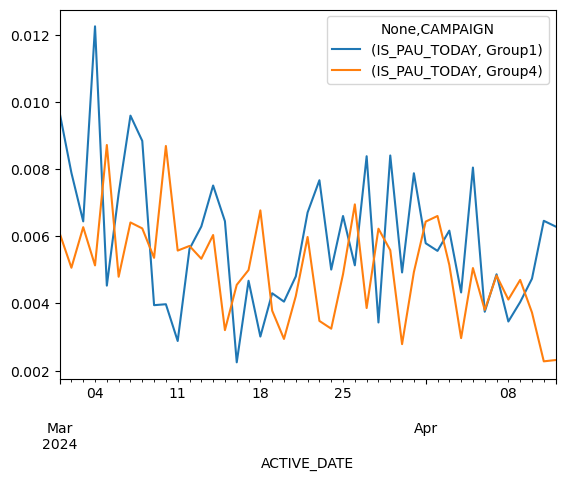

In [75]:
#PUR
print(df2.groupby(['CAMPAIGN', 'ACTIVE_DATE'])['IS_PAU_TODAY'].mean())
# select
#     campaign
#     , active_date
#     , avg(IS_PAU_TODAY)
# from df2 //USER_ACTIVITY_FED

# group by 1, 2
df2 = df2[['CAMPAIGN', 'ACTIVE_DATE', 'IS_PAU_TODAY']]
pd.pivot_table(df2,index = 'ACTIVE_DATE',
               columns = 'CAMPAIGN',aggfunc ='mean').plot.line()

In [76]:
df.groupby('CAMPAIGN')['IS_PAU_TODAY'].mean()

CAMPAIGN
Group1    0.005838
Group4    0.004980
Name: IS_PAU_TODAY, dtype: float64

In [77]:
df.loc[df['IS_PAU_TODAY'] == True].groupby('CAMPAIGN')['FED_ID'].nunique()

CAMPAIGN
Group1    240
Group4    196
Name: FED_ID, dtype: int64

<AxesSubplot:xlabel='ACTIVE_DATE'>

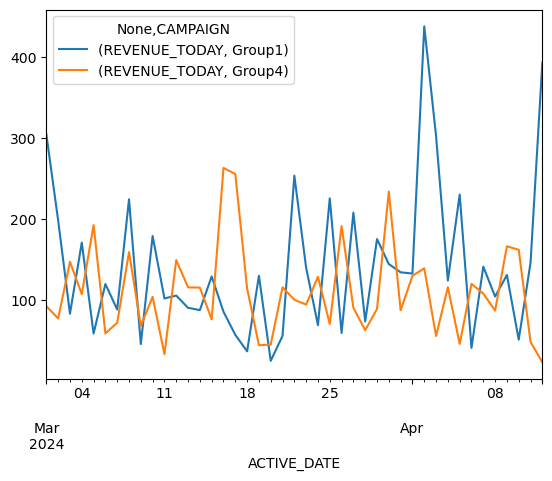

In [78]:
# Sum of Revenue
pd.pivot_table(df[['CAMPAIGN', 'ACTIVE_DATE', 'REVENUE_TODAY']]
               , index = 'ACTIVE_DATE'
               , columns = 'CAMPAIGN',aggfunc ='sum').plot.line()

<AxesSubplot:xlabel='ACTIVE_DATE'>

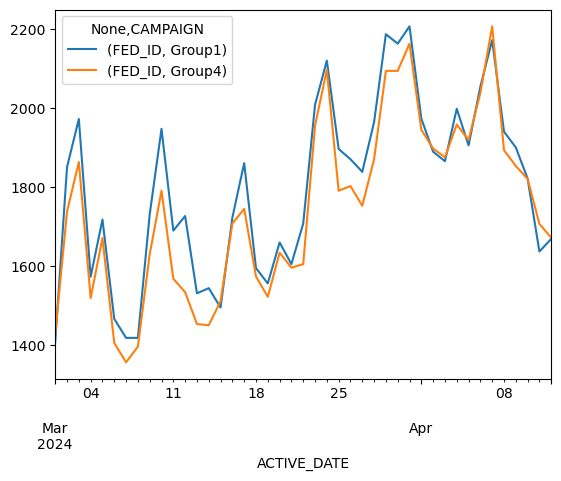

In [79]:
# Number of Players
pd.pivot_table(df[['CAMPAIGN', 'ACTIVE_DATE', 'FED_ID']]
               , index = 'ACTIVE_DATE'
               , columns = 'CAMPAIGN',aggfunc ='nunique').plot.line()

<AxesSubplot:xlabel='ACTIVE_DATE'>

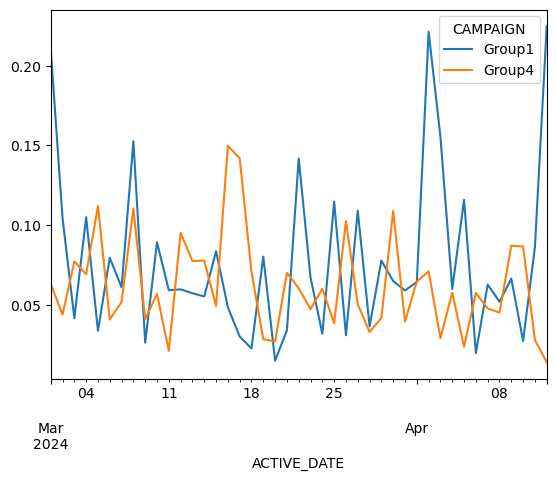

In [80]:
#ARPU
(df.groupby(['CAMPAIGN', 'ACTIVE_DATE'])['REVENUE_TODAY'].sum() / df.groupby(['CAMPAIGN', 'ACTIVE_DATE'])['FED_ID'].count()).unstack('CAMPAIGN').plot.line()

In [81]:
#Average Daily ARPU
(df.groupby(['CAMPAIGN', 'ACTIVE_DATE'])['REVENUE_TODAY'].sum() / df.groupby(['CAMPAIGN', 'ACTIVE_DATE'])['FED_ID'].count()).unstack('CAMPAIGN').mean()

CAMPAIGN
Group1    0.077493
Group4    0.061910
dtype: float64

## 3.3. Bootstrap sampling
##### We sample the data 10000 times and measure the difference between the test groups
The results from the test should be more or less obvious from the previous steps and this is a final confirmation of the results (be it positive or one that states 'inconclusive, needs a better test setup').
* The chart plots the difference between the 2 groups and the 2 lines need to overlap as little as possible.
* The final number is a numerical representation of the chart which is read like 'The test group is better/worse than the control in XX% of the tested 10000 sample cases'

<AxesSubplot:ylabel='Density'>

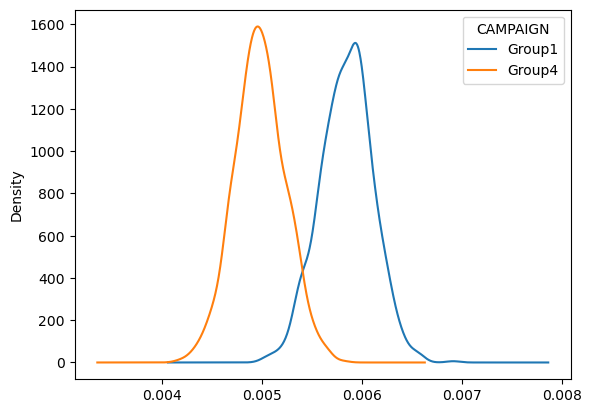

In [104]:
# Bootstrapping based on PUR
boot_means = []
# run the simulation for X times
for i in range(1000): #10000 is better
#set frac=1 → sample all rows
    boot_sample = df.sample(frac=1,replace=True).groupby('CAMPAIGN')['IS_PAU_TODAY'].mean()
    boot_means.append(boot_sample)
# a Pandas DataFrame
boot_means = pd.DataFrame(boot_means)
# kernel density estimate
boot_means.plot(kind = 'kde')

In [105]:
# create a new column, diff, which is the difference between the two variants, scaled by the control group
boot_means['diff']=(boot_means['Group4'] - boot_means['Group1']) /boot_means['Group1']*100
boot_means['diff']

IS_PAU_TODAY   -26.118277
IS_PAU_TODAY   -17.499706
IS_PAU_TODAY   -16.761251
IS_PAU_TODAY   -13.183097
IS_PAU_TODAY   -12.962963
                  ...    
IS_PAU_TODAY   -16.020434
IS_PAU_TODAY    -9.200554
IS_PAU_TODAY    -7.410458
IS_PAU_TODAY   -11.799617
IS_PAU_TODAY   -12.484837
Name: diff, Length: 1000, dtype: float64

Text(0.5, 0, '% diff in means')

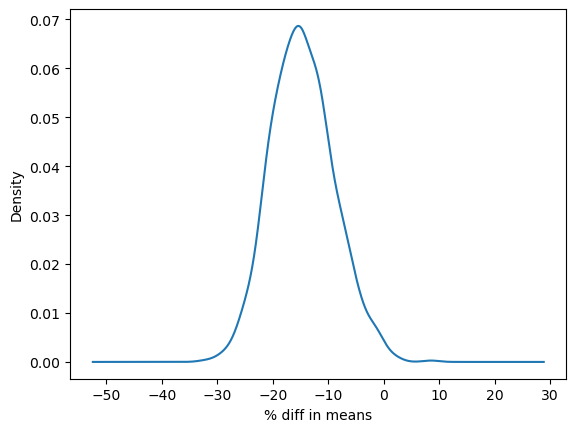

In [106]:
# plot the bootstrap sample difference 
ax = boot_means['diff'].plot(kind = 'kde')
ax.set_xlabel('% diff in means')

In [107]:
boot_means[boot_means['diff'] > 0]
# p value 
p = (boot_means['diff'] >0).sum()/len(boot_means)
p

0.006

<AxesSubplot:ylabel='Density'>

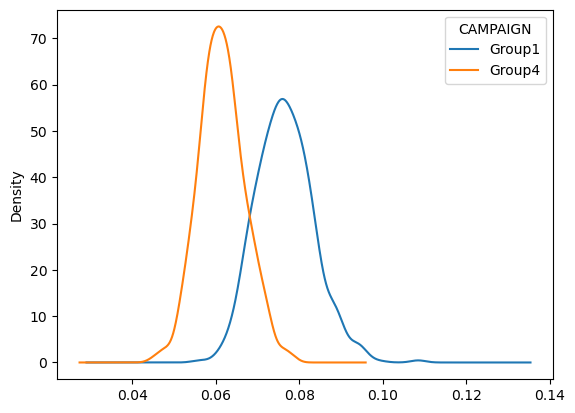

In [108]:
# Bootstrapping based on ARPU
boot_means = []
# run the simulation for X times
for i in range(1000): # 10k is better
#set frac=1 → sample all rows
    boot_sample = df.sample(frac=1,replace=True).groupby('CAMPAIGN')['REVENUE_TODAY'].mean()
    # df.groupby(['CAMPAIGN', 'ACTIVE_DATE'])['REVENUE_TODAY'].sum()
    boot_means.append(boot_sample)
# a Pandas DataFrame
boot_means = pd.DataFrame(boot_means)
# kernel density estimate
boot_means.plot(kind = 'kde')

In [109]:
# create a new column, diff, which is the difference between the two variants, scaled by the control group
boot_means['diff']=(boot_means['Group4'] - boot_means['Group1']) /boot_means['Group1']*100
boot_means['diff']

REVENUE_TODAY   -16.747453
REVENUE_TODAY   -31.013105
REVENUE_TODAY   -10.596313
REVENUE_TODAY   -18.810728
REVENUE_TODAY   -38.905999
                   ...    
REVENUE_TODAY   -34.716067
REVENUE_TODAY   -12.275127
REVENUE_TODAY   -21.909971
REVENUE_TODAY   -34.346629
REVENUE_TODAY   -10.476400
Name: diff, Length: 1000, dtype: float64

Text(0.5, 0, '% diff in means')

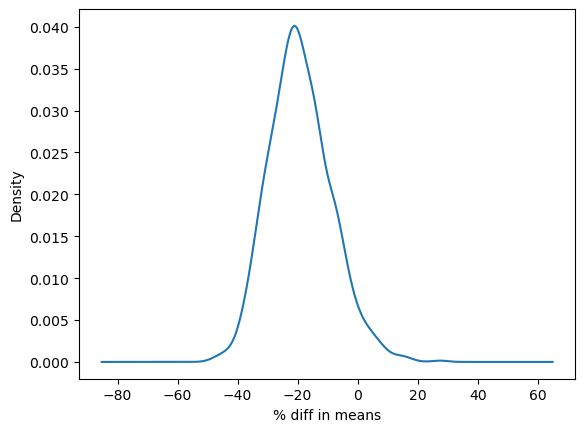

In [110]:
# plot the bootstrap sample difference 
ax = boot_means['diff'].plot(kind = 'kde')
ax.set_xlabel('% diff in means')

In [111]:
boot_means[boot_means['diff'] > 0]
# p value 
p = (boot_means['diff'] > 0).sum()/len(boot_means)
p

0.041